In [1]:
import time
import os
import sys

import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats
from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT
import poppy

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append("/Users/tim/src/cwfs/python")
%cd /Users/tim/MMT/cwfs/

/Users/tim/MMT/cwfs


In [4]:
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile
import lsst.cwfs.plots as plots

In [5]:
p1000_set1_files = [
    "sog_ff_cal_img_2017.1207.083225.fits",
    "sog_ff_cal_img_2017.1207.083329.fits",
    "sog_ff_cal_img_2017.1207.083411.fits"
]
m1000_set1_files = [
    "sog_ff_cal_img_2017.1207.083508.fits",
    "sog_ff_cal_img_2017.1207.083545.fits",
    "sog_ff_cal_img_2017.1207.083625.fits"
]
m1000_set2_files = [
    "sog_ff_cal_img_2017.1207.083737.fits",
    "sog_ff_cal_img_2017.1207.083813.fits",
    "sog_ff_cal_img_2017.1207.083848.fits"
]
p1000_set2_files = [
    "sog_ff_cal_img_2017.1207.083948.fits",
    "sog_ff_cal_img_2017.1207.084024.fits",
    "sog_ff_cal_img_2017.1207.084059.fits"
]

In [6]:
p1000_set1_data = []
for f in p1000_set1_files:
    hdu = fits.open(f)
    data = hdu[1].data
    header = hdu[1].header
    p1000_set1_data.append(data)
p1000_set1_data = np.array(p1000_set1_data)

p1000_set2_data = []
for f in p1000_set2_files:
    hdu = fits.open(f)
    data = hdu[1].data
    header = hdu[1].header
    p1000_set2_data.append(data)
p1000_set2_data = np.array(p1000_set2_data)
    
m1000_set1_data = []
for f in m1000_set1_files:
    hdu = fits.open(f)
    data = hdu[1].data
    header = hdu[1].header
    m1000_set1_data.append(data)
m1000_set1_data = np.array(m1000_set1_data)

m1000_set2_data = []
for f in m1000_set2_files:
    hdu = fits.open(f)
    data = hdu[1].data
    header = hdu[1].header
    m1000_set2_data.append(data)
m1000_set2_data = np.array(m1000_set2_data)

#### Note: at a rotator angle of 0 North is to the right and West is down in sky motion.  With cassegrain flip, the pupil north is then to the left and east is up. This means the wavefront needs to be derotated by -90 deg - rotator angle.

<IPython.core.display.Javascript object>


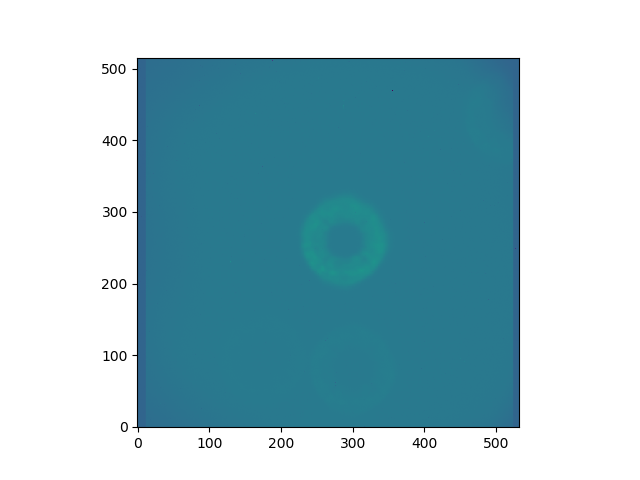

In [7]:
plt.imshow(p1000_set2_data[0], origin="lower")
plt.show()

In [8]:
size = 90
inner = 15
y, x = np.ogrid[-size:size, -size:size]
mask_in = x*x + y*y <= inner*inner
mask_out = x*x + y*y >= size*size
p1000_set1_med = np.median(p1000_set1_data, axis=0)[260-size:260+size,289-size:289+size]
p1000_set2_med = np.median(p1000_set2_data, axis=0)[260-size:260+size,289-size:289+size]
m1000_set1_med = np.median(m1000_set1_data, axis=0)[260-size:260+size,289-size:289+size]
m1000_set2_med = np.median(m1000_set2_data, axis=0)[260-size:260+size,289-size:289+size]
for im in [p1000_set1_med, p1000_set2_med, m1000_set1_med, m1000_set2_med]:
    im -= np.median(im[:,:10])
    im[im < 0] = 0.
#    im[mask_in] = 0.
#|    im[mask_out] = 0.

<IPython.core.display.Javascript object>


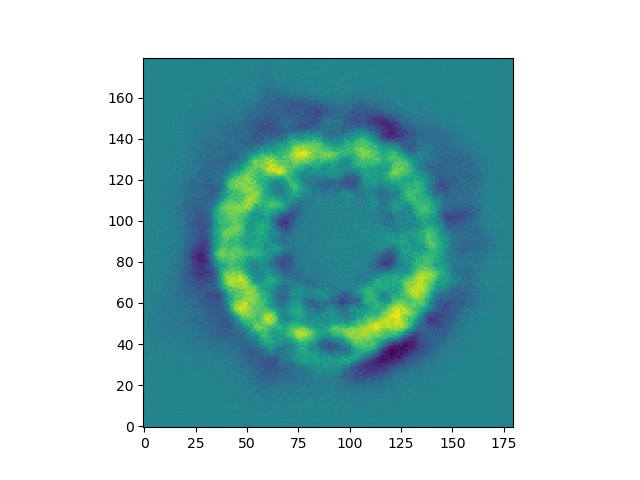

(180, 180)

In [9]:
plt.imshow(p1000_set1_med - m1000_set1_med, origin="lower")
plt.show()
p1000_set2_med.shape

In [10]:
set1 = p1000_set1_med - m1000_set1_med
set2 = p1000_set2_med - m1000_set2_med

In [11]:
fits.writeto("p1000_s1.fits", p1000_set1_med, overwrite=True)
fits.writeto("p1000_s2.fits", p1000_set2_med, overwrite=True)
fits.writeto("m1000_s1.fits", m1000_set1_med, overwrite=True)
fits.writeto("m1000_s2.fits", m1000_set2_med, overwrite=True)

In [12]:
fieldXY = [0., 0.]
I1 = Image(readFile("p1000_s2.fits"), fieldXY, Image.INTRA)
I2 = Image(readFile("m1000_s2.fits"), fieldXY, Image.EXTRA)

<IPython.core.display.Javascript object>


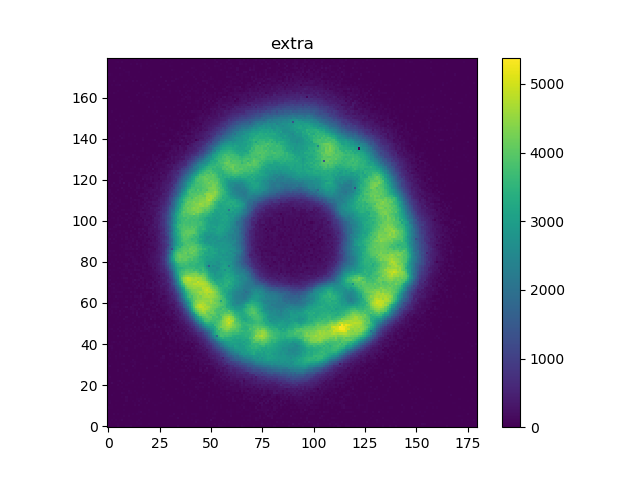

In [13]:
plots.plotImage(I1.image, 'extra')

In [14]:
mmt = Instrument('mmto', I1.sizeinPix)

In [15]:
# this is a hack. 0.0 doesn't work, but this will yield annular zernike solution that is very close to circular.
mmt.obscuration = 0.01

In [16]:
algo = Algorithm('exp', mmt, 3)

In [17]:
algo.runIt(mmt, I1, I2, 'onAxis')

resetting images: I1 and I2
imageCoCenter: (x1,y1)=(   90.19,   90.05)

imageCoCenter: (x1,y1)=(   92.27,   89.71)

itr = 0, z4-z22
[ -79.  277. -180.  -92.  149.  161.  -19.  434.   99.  -85.  -26.   59.
  -27.    9.   -2.  -38.  -18.   18. -131.]
itr = 1, z4-z22
[ -89.  280. -174.  -97.  134.  159.  -19.  436.   98.  -85.  -26.   58.
  -10.   15.   -2.  -37.  -17.   18. -134.]
itr = 2, z4-z22
[ -93.  270. -183.  -90.  153.  152.  -25.  433.  100.  -85.  -29.   61.
  -29.    7.   -1.  -39.  -18.   21. -134.]
itr = 3, z4-z22
[ -93.  313. -210.  -96.  137.  149.  -27.  435.   97.  -81.  -29.   60.
  -11.   13.   -1.  -39.  -17.   21. -136.]
itr = 4, z4-z22
[ -93.  326. -229. -100.  154.  149.  -31.  434.   96.  -78.  -29.   59.
  -29.   17.   -1.  -39.  -18.   20. -136.]
itr = 5, z4-z22
[ 159.  272. -159.  -95.  140.  184.  -17.  438.  107.  -83.  -21.   53.
  -17.   18.   -6.  -33.  -13.   17.  -82.]
itr = 6, z4-z22
[ 307.  234. -129. -113.  137.  185.  -14.  438.  116.  -86.  -21.   5

In [18]:
print(algo.zer4UpNm)

[ 324.86851144  176.59954386  -35.26438879  -88.84193532  130.17887354
  145.01732601   -2.14505932  435.40023487  120.73792372  -91.03016084
  -20.69039018   68.85365261  -10.81872128   15.12097693   -7.78472002
  -39.60854392  -16.20407111   19.28210975  -44.15358077]


<IPython.core.display.Javascript object>


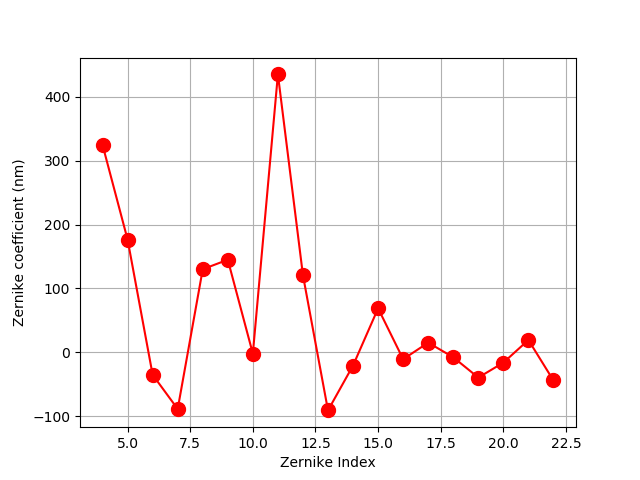

In [19]:
plots.plotZer(algo.zer4UpNm, 'nm')

In [20]:
zv = ZernikeVector()
zv.from_array(algo.zer4UpNm, modestart=4, normalized=True)
zv.denormalize()

In [22]:
zv

Fringe Coefficients
 Z04:       563 nm 	 Defocus (2, 0)
 Z05:       433 nm 	 Primary Astig at 45° (2, -2)
 Z06:     -86.4 nm 	 Primary Astig at 0° (2, 2)
 Z07:      -251 nm 	 Primary Y Coma (3, -1)
 Z08:       368 nm 	 Primary X Coma (3, 1)
 Z09:       410 nm 	 Y Trefoil (3, -3)
 Z10:     -6.07 nm 	 X Trefoil (3, 3)
 Z11:       974 nm 	 Primary Spherical (4, 0)
 Z12:       382 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:      -288 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:     -65.4 nm 	 X Tetrafoil (4, 4)
 Z15:       218 nm 	 Y Tetrafoil (4, -4)
 Z16:     -37.5 nm 	 Secondary X Coma (5, 1)
 Z17:      52.4 nm 	 Secondary Y Coma (5, -1)
 Z18:       -27 nm 	 Secondary X Trefoil (5, 3)
 Z19:      -137 nm 	 Secondary Y Trefoil (5, -3)
 Z20:     -56.1 nm 	 X Pentafoil (5, 5)
 Z21:      66.8 nm 	 Y Pentafoil (5, -5)
 Z22:      -117 nm 	 Secondary Spherical (6, 0)

<IPython.core.display.Javascript object>


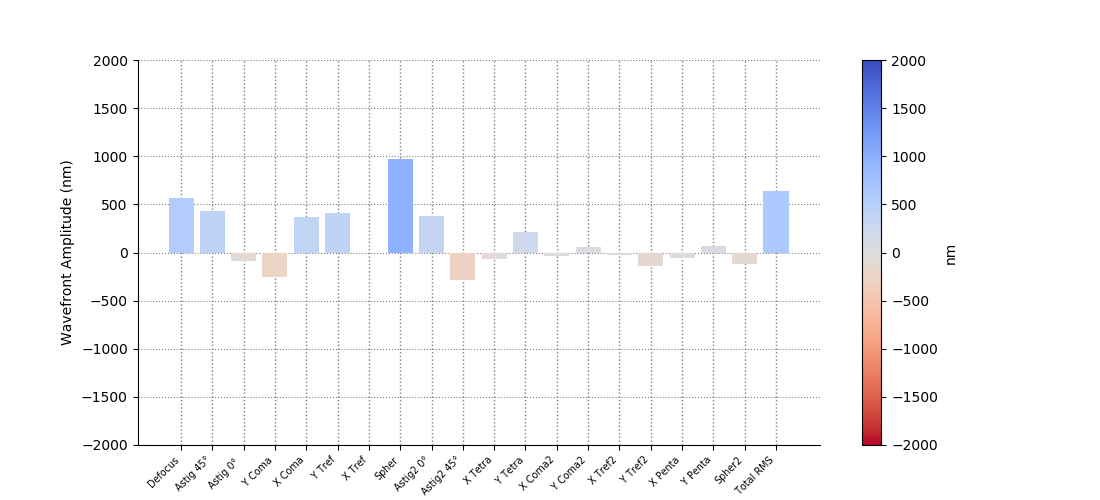

In [32]:
zv.fringe_bar_chart().show()

<IPython.core.display.Javascript object>


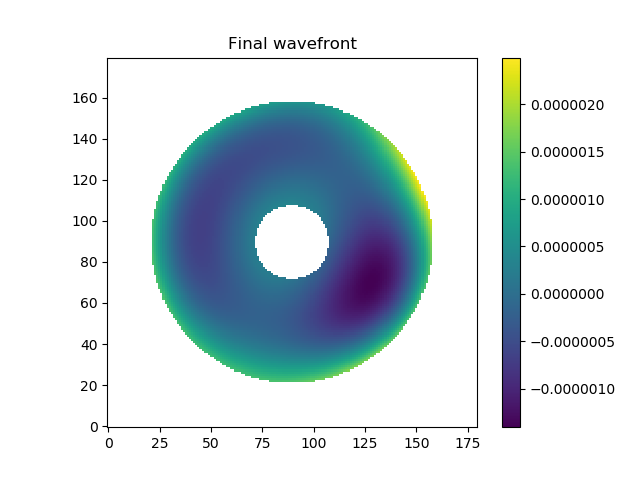

In [27]:
plots.plotImage(algo.Wconverge, "Final wavefront")

In [29]:
I1 = Image(readFile("p1000_s2.fits"), fieldXY, Image.INTRA)
I2 = Image(readFile("m1000_s2.fits"), fieldXY, Image.EXTRA)
algo2 = Algorithm('fft', mmt, 3)
algo2.itr0(mmt, I1, I2, 'onAxis')

resetting images: I1 and I2
imageCoCenter: (x1,y1)=(   90.19,   90.05)

imageCoCenter: (x1,y1)=(   92.27,   89.71)

iOuter=0, cliplevel=0.33
(256, 256)
itr = 0, z4-z22
[ 139.  246.   71.  -63.   17.  195.  -38.  292.   50.  -93.  -33.   95.
   45.   13.   14.  -36.   -1.   25.  -74.]


<IPython.core.display.Javascript object>


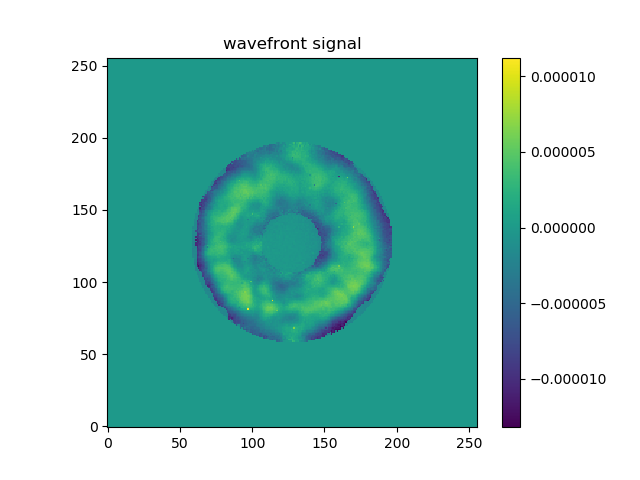

In [31]:
plots.plotImage(algo2.S, 'wavefront signal')

In [ ]:
plt.close('all')